In [23]:
#| hide
import sys
sys.path.append('../.venv/lib/python3.9/site-packages/')

In [25]:
!jupyter kernelspec list

Available kernels:
  python3    /opt/anaconda3/share/jupyter/kernels/python3
  ir         /usr/local/share/jupyter/kernels/ir
  rapids     /usr/local/share/jupyter/kernels/rapids


# Model Salience Estimation

Model salience has been used extensively in the XAI community to help interpret why models make their decisions. One of the most popular salience methods is Gradient-Weighted Class Activation Mappings (Grad-CAMs), which visulaizes the gradients of the predicted class at the final convolutional layer.

In [2]:
import torch

## Necessary Arguments

In [3]:
model_path = "../models/weights/Densenet/densenet_cyborg_1/Logs/final_model.pth"
device = torch.device('cpu')
network = "densenet"

## Loading the Model

In [4]:
import torchvision.models as models
import torch.nn as nn

First, load in the weights

In [5]:
weights = torch.load(model_path, map_location=device)

Now, load weights on a single binary DesNet121 model

In [6]:
if network == "resnet":
    im_size = 224
    model = models.resnet50(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif network == "inception":
    im_size = 299
    model = models.inception_v3(pretrained=True,aux_logits=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
elif network == "xception":
    im_size = 299
    model, *_ = model_selection(modelname='xception', num_out_classes=2)
else: # else DenseNet
    im_size = 224
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 2)

/afs/crc.nd.edu/group/TAI/Users/painswor/Explain2Me-Framework-Example/nbs/../.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/afs/crc.nd.edu/group/TAI/Users/painswor/Explain2Me-Framework-Example/nbs/../.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
target_layers = [model.features[-1]]
model.load_state_dict(weights['state_dict'])
model = model.to(device)
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## Preprocessing

In [8]:
import torchvision.transforms as transforms

In [9]:
if network == "xception":
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize([0.5]*3, [0.5]*3)
            ])
else:
    # Transformation specified for the pre-processing
    transform = transforms.Compose([
                transforms.Resize([im_size, im_size]),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [10]:
imageScores = []
sigmoid = nn.Sigmoid()

## Creating GradCam

In [26]:
from PIL import Image
from torchcam.methods import GradCAM
from torchcam.methods import GradCAMpp
import skimage.io

Laod the image

In [12]:
gradcamType = "gradcam"
img_name = "00001.png"
img_path = f'../data/images/ffhq_aligned/{img_name}'

In [13]:
# Loading in the image
image = Image.open(img_path).convert('RGB')

# Image transformation
input_tensor = transform(image)

Generate GradCAM

In [14]:
if gradcamType == "gradcam":
    #cam_extractor = GradCAM(model, target_layers)
    cam_extractor = GradCAM(model)
elif gradcamType == "gradcamPP":
    cam_extractor = GradCAMpp(model, target_layers)

## Processing GradCAM

In [15]:
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask

Preprocess your data and feed it to the model

In [16]:
size = 'upscaled'

In [17]:
out = model(input_tensor.unsqueeze(0))

Retrieve the CAM by passing class index and model output

In [18]:
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

In [19]:
cam = to_pil_image(activation_map[0].squeeze(0), mode='F')
cam = overlay_mask(image, cam, alpha=0.50)
if size == 'upscaled':
    cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)

/tmp/ipykernel_2096218/982827863.py:4: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  cam = cam.resize((im_size, im_size), resample = Image.BICUBIC)


## Display GradCAM

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

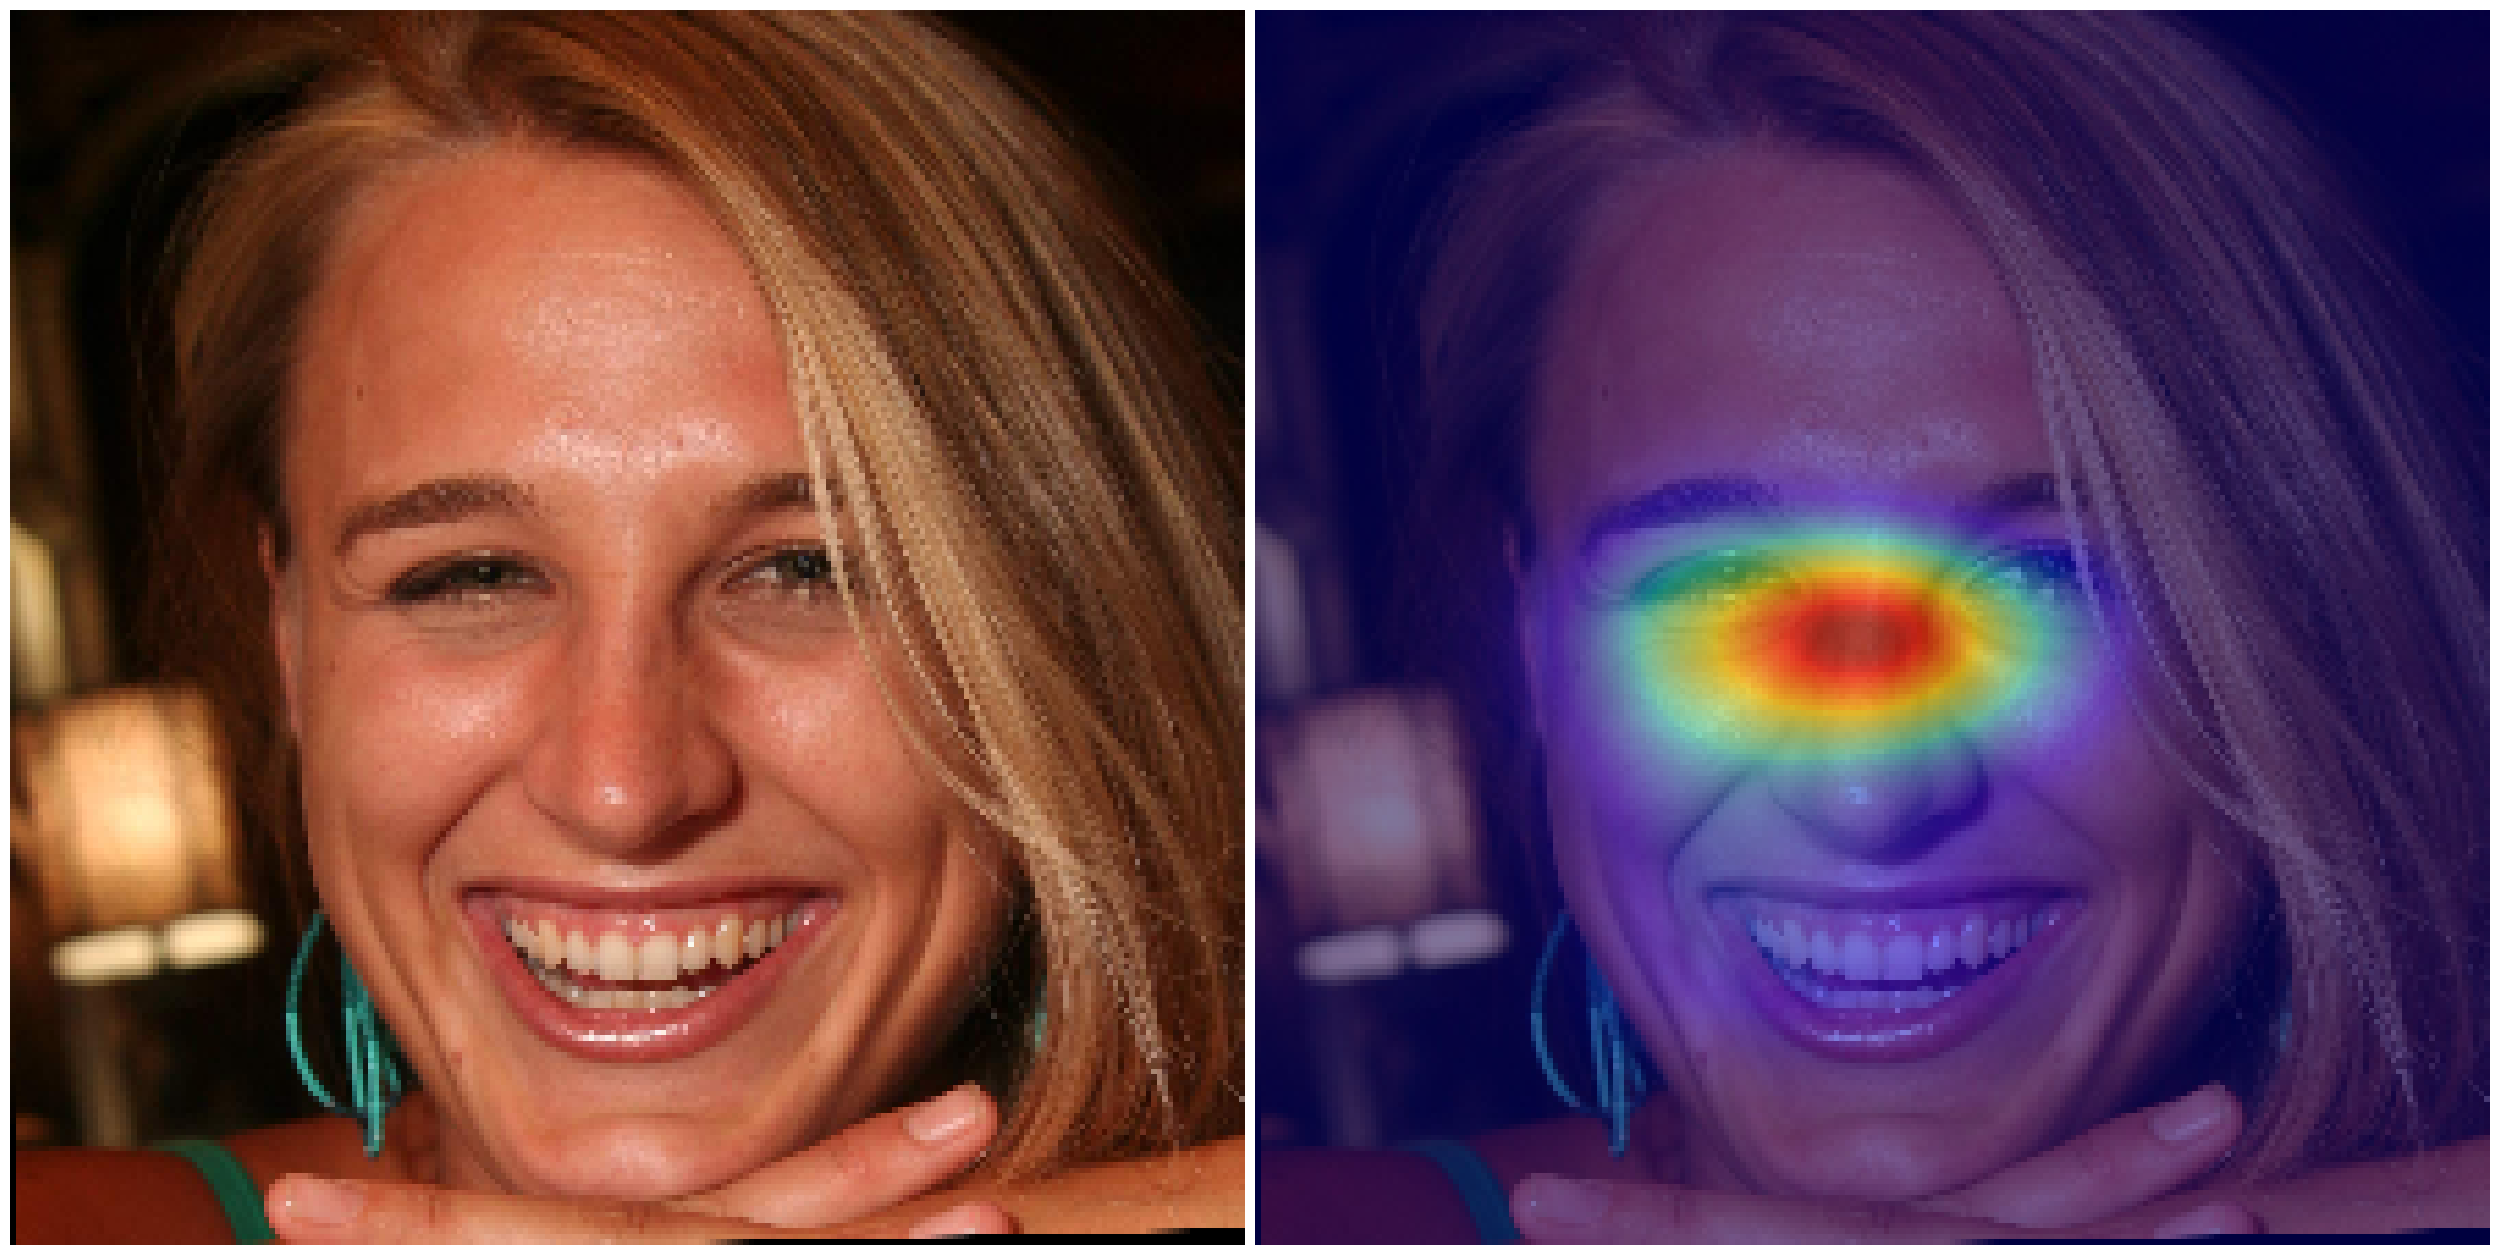

In [28]:
original_image = Image.open(img_path).convert('RGB')
overlayed_cam = cam

fig = plt.figure(figsize=(10., 8.), facecolor='white')
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 aspect=1.2
                 )

for index, (ax, im) in enumerate(zip(grid, [original_image, overlayed_cam])):
    # Iterating over the grid returns the Axes.
    ax.axis('off')
    ax.grid(None)
    ax.imshow(im)
    #ax.set_title(predictions[index], fontsize=45)
fig.set_size_inches(32, 18)
plt.show()

In [22]:
save_directory = f'../output/cams/{img_name}'
cam.save(save_directory)